In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(r"data\vgsales_clean.csv")

In [4]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df["G"]

# Game Analytics: Video Game Sales & Success Prediction

## Obiettivi
1. **Analisi per Piattaforma e Genere**: Quale combinazione ha performato meglio?
2. **Impatto Recensioni**: Quanto contano critica e rating sul successo?
3. **Hit Prediction ML**: Stimare la probabilità di raggiungere ≥1M copie
4. **Natural Language Query**: Interrogare i dati in italiano

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Setup visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Esplorazione Dati Base

In [6]:
print(f"Dataset Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistiche Vendite Globali:\n{df['Global_Sales'].describe()}")

Dataset Shape: (16719, 16)

Data Types:
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

Missing Values:
Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Statistiche Vendite Globali:
count    16719.000000
mean         0.533543
std          1.547935
min 

## 2. Piattaforme e Generi: Cosa Ha Funzionato?

In [7]:
# Top 10 Piattaforme per Vendite Globali
platform_sales = df.groupby('Platform')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("TOP PIATTAFORME (per Vendite Globali Totali):")
print(platform_sales.head(10))

# Top 10 Generi
genre_sales = df.groupby('Genre')['Global_Sales'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\n\nTOP GENERI (per Vendite Globali Totali):")
print(genre_sales)

TOP PIATTAFORME (per Vendite Globali Totali):
              sum  count      mean
Platform                          
PS2       1255.64   2161  0.581046
X360       971.63   1262  0.769913
PS3        939.43   1331  0.705808
Wii        908.13   1320  0.687977
DS         807.10   2152  0.375046
PS         730.68   1197  0.610426
GBA        318.50    822  0.387470
PS4        314.23    393  0.799567
PSP        294.30   1209  0.243424
PC         260.30    974  0.267248


TOP GENERI (per Vendite Globali Totali):
                  sum  count      mean
Genre                                 
Action        1745.27   3370  0.517884
Sports        1332.00   2348  0.567291
Shooter       1052.94   1323  0.795873
Role-Playing   934.40   1500  0.622933
Platform       828.08    888  0.932523
Misc           803.18   1750  0.458960
Racing         728.90   1249  0.583587
Fighting       447.48    849  0.527067
Simulation     390.42    874  0.446705
Puzzle         243.02    580  0.419000
Adventure      237.69  

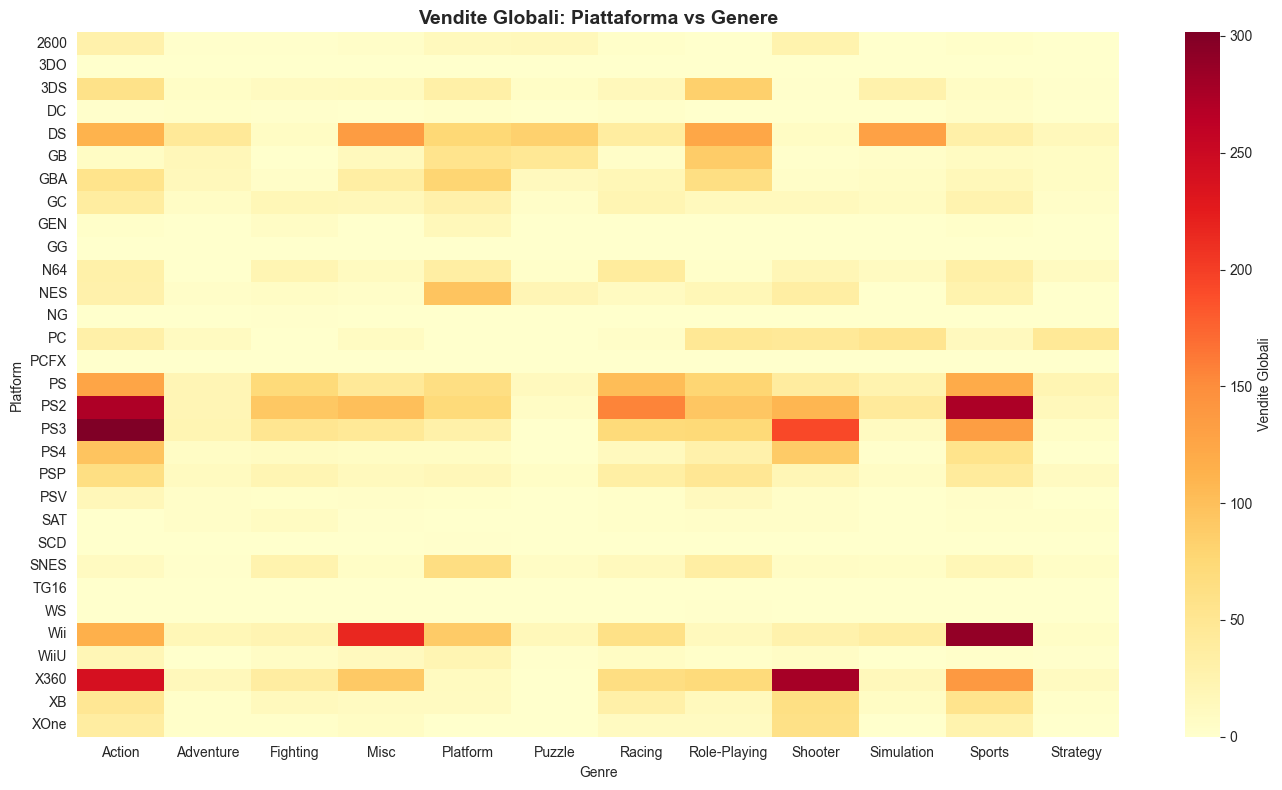

In [8]:
# Heatmap Piattaforma vs Genere
platform_genre = df.pivot_table(values='Global_Sales', index='Platform', columns='Genre', aggfunc='sum', fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(platform_genre, cmap='YlOrRd', annot=False, fmt='.0f', cbar_kws={'label': 'Vendite Globali'})
plt.title('Vendite Globali: Piattaforma vs Genere', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Trend nel Tempo (Anno di Uscita)

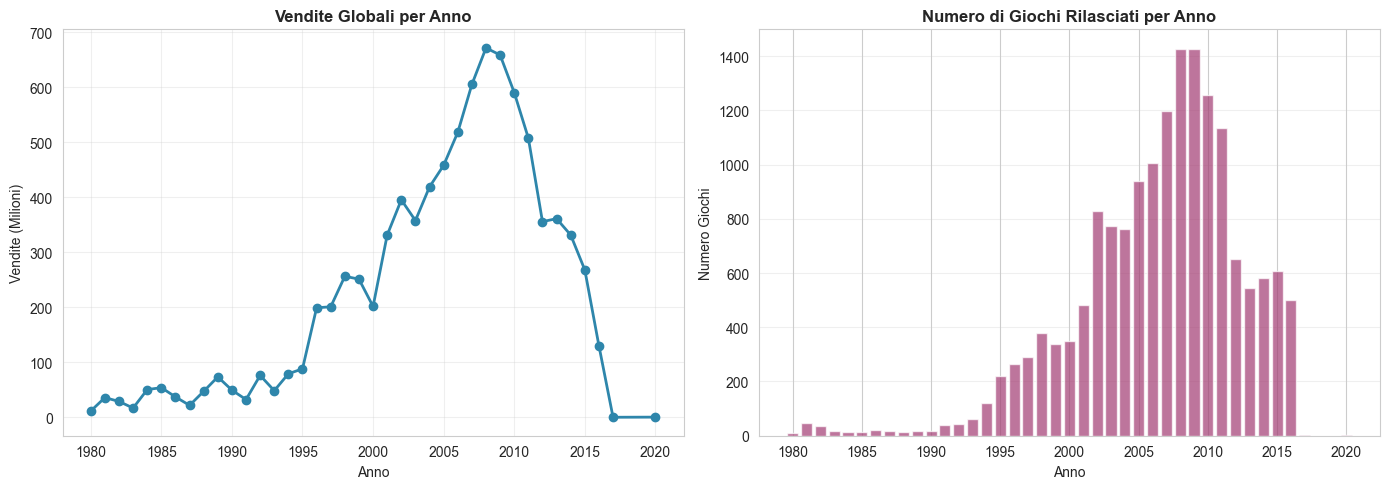

In [9]:
yearly_sales = df.groupby('Year_of_Release')['Global_Sales'].agg(['sum', 'count']).reset_index()
yearly_sales = yearly_sales[yearly_sales['Year_of_Release'].notna()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Vendite totali per anno
ax1.plot(yearly_sales['Year_of_Release'], yearly_sales['sum'], marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.set_title('Vendite Globali per Anno', fontsize=12, fontweight='bold')
ax1.set_xlabel('Anno')
ax1.set_ylabel('Vendite (Milioni)')
ax1.grid(True, alpha=0.3)

# Numero di giochi per anno
ax2.bar(yearly_sales['Year_of_Release'], yearly_sales['count'], color='#A23B72', alpha=0.7)
ax2.set_title('Numero di Giochi Rilasciati per Anno', fontsize=12, fontweight='bold')
ax2.set_xlabel('Anno')
ax2.set_ylabel('Numero Giochi')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Impatto Recensioni e Rating sulle Vendite

In [10]:
# Pulizia: considera solo giochi con score (non NaN)
df_scores = df.dropna(subset=['Critic_Score', 'User_Score', 'Global_Sales'])

# Converti User_Score da object a float (se necessario)
df_scores['User_Score'] = pd.to_numeric(df_scores['User_Score'], errors='coerce')
df_scores = df_scores.dropna(subset=['User_Score'])

print(f"Giochi con score: {len(df_scores)} su {len(df)}")
print(f"\nCorrelazione con Vendite Globali:")
correlations = df_scores[['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']].corr()['Global_Sales'].sort_values(ascending=False)
print(correlations)

Giochi con score: 7017 su 16719

Correlazione con Vendite Globali:
Global_Sales    1.000000
Critic_Count    0.289301
User_Count      0.262935
Critic_Score    0.236953
User_Score      0.088583
Name: Global_Sales, dtype: float64


C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_6452\4283605323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scores['User_Score'] = pd.to_numeric(df_scores['User_Score'], errors='coerce')


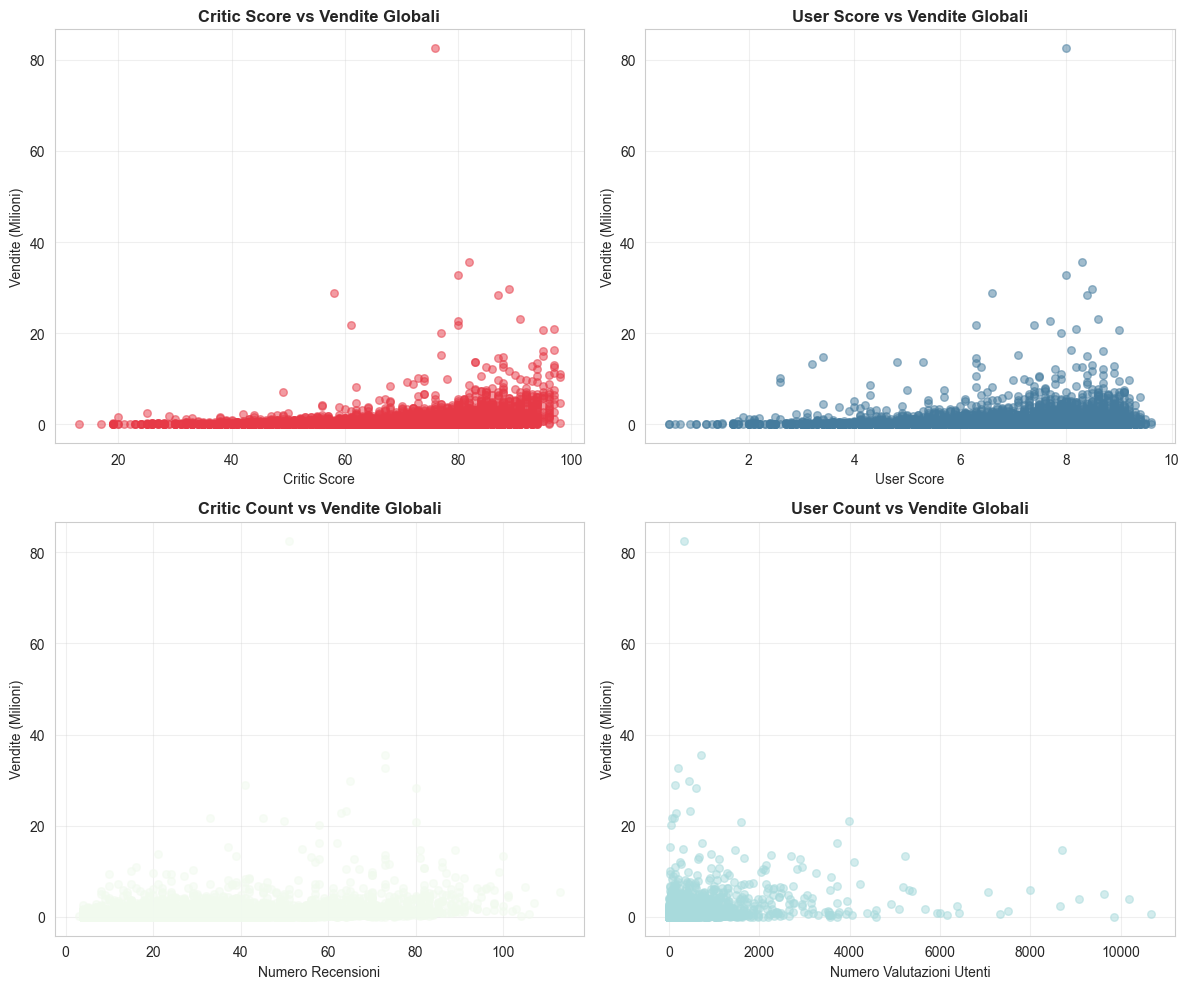

In [11]:
# Scatter plot: Critic Score vs Vendite
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Critic Score
axes[0, 0].scatter(df_scores['Critic_Score'], df_scores['Global_Sales'], alpha=0.5, s=30, color='#E63946')
axes[0, 0].set_title('Critic Score vs Vendite Globali', fontweight='bold')
axes[0, 0].set_xlabel('Critic Score')
axes[0, 0].set_ylabel('Vendite (Milioni)')
axes[0, 0].grid(True, alpha=0.3)

# User Score
axes[0, 1].scatter(df_scores['User_Score'], df_scores['Global_Sales'], alpha=0.5, s=30, color='#457B9D')
axes[0, 1].set_title('User Score vs Vendite Globali', fontweight='bold')
axes[0, 1].set_xlabel('User Score')
axes[0, 1].set_ylabel('Vendite (Milioni)')
axes[0, 1].grid(True, alpha=0.3)

# Critic Count
axes[1, 0].scatter(df_scores['Critic_Count'], df_scores['Global_Sales'], alpha=0.5, s=30, color='#F1FAEE')
axes[1, 0].set_title('Critic Count vs Vendite Globali', fontweight='bold')
axes[1, 0].set_xlabel('Numero Recensioni')
axes[1, 0].set_ylabel('Vendite (Milioni)')
axes[1, 0].grid(True, alpha=0.3)

# User Count
axes[1, 1].scatter(df_scores['User_Count'], df_scores['Global_Sales'], alpha=0.5, s=30, color='#A8DADC')
axes[1, 1].set_title('User Count vs Vendite Globali', fontweight='bold')
axes[1, 1].set_xlabel('Numero Valutazioni Utenti')
axes[1, 1].set_ylabel('Vendite (Milioni)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Hit Prediction: Modello ML per Prevedere Giochi Vincenti

In [12]:
# Definisci "HIT" come gioco con ≥1M copie vendute
df_ml = df.dropna(subset=['Genre', 'Platform', 'Year_of_Release', 'Global_Sales']).copy()
df_ml['is_hit'] = (df_ml['Global_Sales'] >= 1.0).astype(int)

print(f"Distribuzione Hit vs Non-Hit:")
print(df_ml['is_hit'].value_counts())
print(f"\nPercentuale di Hit: {df_ml['is_hit'].mean()*100:.1f}%")

# Seleziona features per il modello
# Encode categorie
le_platform = LabelEncoder()
le_genre = LabelEncoder()
le_rating = LabelEncoder()

df_ml['Platform_enc'] = le_platform.fit_transform(df_ml['Platform'])
df_ml['Genre_enc'] = le_genre.fit_transform(df_ml['Genre'])
df_ml['Rating_enc'] = le_rating.fit_transform(df_ml['Rating'].fillna('Unknown'))

# Features numeriche e categoriche
feature_cols = ['Platform_enc', 'Genre_enc', 'Year_of_Release', 'Rating_enc',
                'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']

# Riempi i NaN nelle features
for col in feature_cols:
    if df_ml[col].dtype in ['float64', 'int64']:
        df_ml[col].fillna(df_ml[col].median(), inplace=True)

X = df_ml[feature_cols]
y = df_ml['is_hit']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {len(X_train)} | Test set: {len(X_test)}")

Distribuzione Hit vs Non-Hit:
is_hit
0    14395
1     2053
Name: count, dtype: int64

Percentuale di Hit: 12.5%

Train set: 13158 | Test set: 3290


C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_6452\3225105217.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml[col].fillna(df_ml[col].median(), inplace=True)
C:\Users\AshleyDaveAustria\AppData\Local\Temp\ipykernel_6452\3225105217.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always